## Etapa 1- Segmentacion
El script tiene como objetivo dividir un archivo de audio largo en fragmentos más pequeños que potencialmente contienen cantos de aves. Para lograrlo, se utiliza la energía de la señal (RMS) como criterio de detección: se calcula la energía de cada fragmento sin solapamiento, y solo se guardan aquellos cuya energía supera un umbral definido por el usuario, lo que indica la posible presencia de sonido relevante (como vocalizaciones de aves). La función dividir_audio_canto toma como entrada la ruta del archivo .wav original, la duración deseada para los fragmentos, un valor umbral de energía y la carpeta donde se guardarán los fragmentos. En el bloque de código principal, la variable archivo_entrada define la ubicación del archivo de audio original que se quiere procesar (esta ruta debe ser modificada para que puedas apuntar al archivo específico que deseas segmentar). Por otro lado, ruta_salida corresponde a la carpeta donde se guardarán los fragmentos resultantes.

In [ ]:
import librosa
import numpy as np
import os
import soundfile as sf


def dividir_audio_canto(archivo_entrada, duracion_fragmento_segundos, umbral_energia, ruta_salida):
    audio, sr = librosa.load(archivo_entrada, sr=None, mono=True)
    
    frame_length = int(duracion_fragmento_segundos * sr)
    hop_length = frame_length  

    energia = librosa.feature.rms(y=audio, frame_length=frame_length, hop_length=hop_length)[0]

    if not os.path.exists(ruta_salida):
        os.makedirs(ruta_salida)

    fragmentos = []
    for i, e in enumerate(energia):
        if e > umbral_energia:
            start_sample = i * hop_length
            end_sample = start_sample + frame_length
            fragmento = audio[start_sample:end_sample]
            archivo_salida = os.path.join(ruta_salida, f"fragmento_{i + 1}.wav")
            sf.write(archivo_salida, fragmento, sr)
            fragmentos.append(archivo_salida)

    return fragmentos


archivo_entrada = r"D:\GUSTAVO\Grabaciones originales"
ruta_salida = r"D:\GUSTAVO\FRACMENTO\GRABADORA 2"

umbral_energia = 0.05
duracion_fragmento_segundos = 6


fragmentos = dividir_audio_canto(archivo_entrada, duracion_fragmento_segundos, umbral_energia, ruta_salida)
print(f"Fragmentos guardados en: {ruta_salida}")


## Subetapa 1- Saber confianza de tus audios fragmentados
Este script se encarga de analizar automáticamente múltiples fragmentos de audio .wav usando BirdNET con el fin de saber la calidad de tu audios o hacer un dataset propio y por ultimo hacer una comparacion con la confianza de los audios ya filtrados, con la confianza puedes saber si es un audio con ave o sin uno. Para poder utilizarlo, debes modificar tres rutas clave al comienzo del código: CARPETA_FRAGMENTOS, que es donde tienes guardados los audios ya segmentados; CARPETA_SALIDA_BIRDNET, que es la carpeta donde se van a guardar los resultados del análisis en formato .csv; y CARPETA_BIRDNET, que es la ruta local donde tienes descargado el repositorio de BirdNET Analyzer. También puedes ajustar algunos parámetros como la latitud (LAT), longitud (LON), sensibilidad (SENS) y el mínimo de confianza (MIN_CONF) para personalizar la detección según tu ubicación o tus necesidades. Lo que hace el script es ordenar los archivos por número, analizarlos uno por uno usando varios núcleos del procesador (hasta 20 como máximo para mi caso, puede variarlo dependiendo de su procesador), y luego verifica que se haya generado correctamente el archivo .csv para cada fragmento. 

In [ ]:
import os
import subprocess
import re
from multiprocessing import Pool


CARPETA_FRAGMENTOS = r"D:\GUSTAVO\FRACMENTO\GRABADORA 2"
CARPETA_SALIDA_BIRDNET = r"D:\GUSTAVO\salida_birdnet"
CARPETA_BIRDNET = r"D:\GUSTAVO\BirdNET-Analyzer-main"


LAT = "4.57"
LON = "-74.29"
MIN_CONF = "0.01"
SENS = "1.0"


def extraer_numero(archivo):
    match = re.search(r"(\d+)", archivo)
    return int(match.group()) if match else -1


def analizar_archivo(archivo):
    try:
        ruta_audio = os.path.join(CARPETA_FRAGMENTOS, archivo)
        base = os.path.splitext(archivo)[0]
        ruta_csv = os.path.join(CARPETA_SALIDA_BIRDNET, base + ".BirdNET.csv")

        print(f"\n Analizando: {archivo}")

        comando = [
            "python", "-m", "birdnet_analyzer.analyze",
            ruta_audio,
            "--output", CARPETA_SALIDA_BIRDNET,
            "--lat", LAT,
            "--lon", LON,
            "--sensitivity", SENS,
            "--min_conf", MIN_CONF
        ]

        resultado = subprocess.run(
            comando,
            cwd=CARPETA_BIRDNET,
            stdout=subprocess.PIPE,
            stderr=subprocess.PIPE,
            check=True
        )

        if os.path.exists(ruta_csv):
            print(f" CSV generado: {ruta_csv}")
        else:
            print(f" CSV no generado para: {archivo}")

        if resultado.stderr:
            print(" STDERR:")
            print(resultado.stderr.decode("utf-8"))

    except subprocess.CalledProcessError as e:
        print(f" Error procesando {archivo}:")
        print(e.stderr.decode("utf-8"))
    except Exception as e:
        print(f" Error inesperado en {archivo}: {str(e)}")


if __name__ == "__main__":
    archivos_wav = sorted(
        [f for f in os.listdir(CARPETA_FRAGMENTOS) if f.lower().endswith(".wav")],
        key=extraer_numero
    )

    print(f" Se encontraron {len(archivos_wav)} archivos .wav para analizar.")
    
    NUM_PROCESOS = min(20, os.cpu_count())  
    print(f" Procesando con {NUM_PROCESOS} núcleos...")

    with Pool(NUM_PROCESOS) as pool:
        pool.map(analizar_archivo, archivos_wav)

    print("\n Análisis completado.")


## Experimento 1 - Cuantas epocas y pasos son necesarios para obtener la mejor confianza?

Este script fue diseñado como un experimento para explorar cuántas épocas y pasos de aprendizaje por refuerzo (Q-learning) son necesarios para alcanzar la mayor confianza posible en la detección de cantos de aves usando BirdNET. La meta era ver a que numero de epocas y pasos era posible encontrar la mejor combinación de filtros de señal (Kalman + pasabanda) que maximice el rendimiento del modelo de clasificación.

El código implementa un sistema automatizado que prueba múltiples combinaciones de parámetros de filtrado sobre fragmentos de audio reales, evaluando el resultado con BirdNET. Los valores de confianza obtenidos se usan como recompensas para entrenar un agente Q-learning que optimiza progresivamente las decisiones de filtrado.

---

### Variables clave que debe ajustar el usuario

- **`BASE_DIR`**: Ruta principal donde se almacenan resultados y archivos temporales.
- **`AUDIO_DIR`**: Carpeta donde están los audios `.wav` a analizar.
- **`Q_VALS`, `R_VALS`, `F_VALS`**: Rangos de parámetros para los filtros Kalman y pasabanda.
- **`N_EPOCHS`, `MAX_STEPS`**: Controlan la duración del entrenamiento (cantidad de pruebas realizadas por audio).
- **`EPSILON`, `GAMMA`, `ALPHA`**: Hiperparámetros del agente Q-learning.

El código genera gráficas del proceso de entrenamiento con los resultados obtenidos por audio. Al finalizar, se puede observar como influye los pasos y las epocas con la confianza que va obteniendo el agente Q-learning con los valores de acciones estipulados.



📋 Época 1/9 - Audio: fragmento_1787
📊 Mejor Confianza esta época: 0.829

📋 Época 2/9 - Audio: fragmento_1787
📊 Mejor Confianza esta época: 0.829

📋 Época 3/9 - Audio: fragmento_1787
📊 Mejor Confianza esta época: 0.828


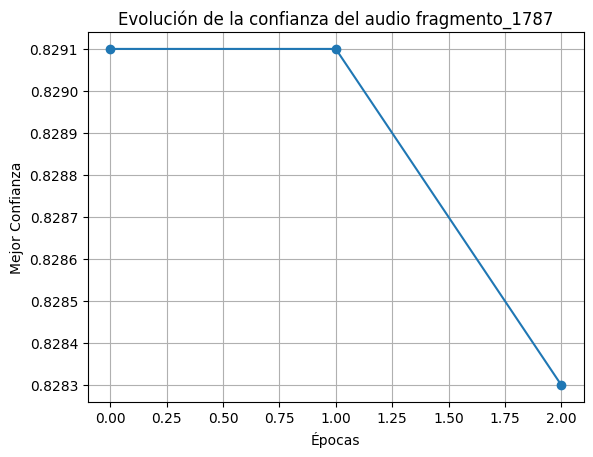


📋 Época 4/9 - Audio: fragmento_1787
📊 Mejor Confianza esta época: 0.848

📋 Época 5/9 - Audio: fragmento_1787
📊 Mejor Confianza esta época: 0.830

📋 Época 6/9 - Audio: fragmento_1787
📊 Mejor Confianza esta época: 0.829


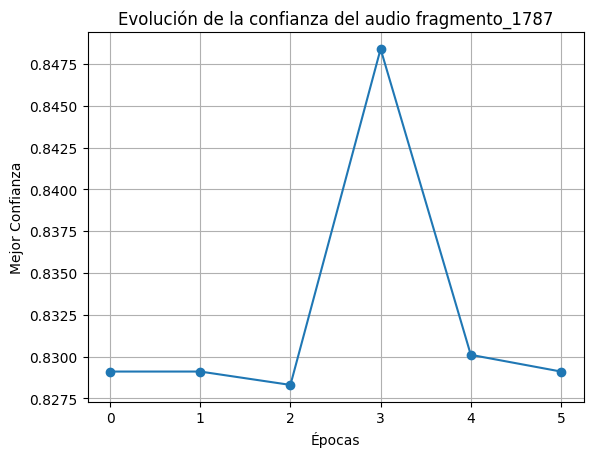


📋 Época 7/9 - Audio: fragmento_1787
📊 Mejor Confianza esta época: 0.830

📋 Época 8/9 - Audio: fragmento_1787
📊 Mejor Confianza esta época: 0.829

📋 Época 9/9 - Audio: fragmento_1787
📊 Mejor Confianza esta época: 0.829


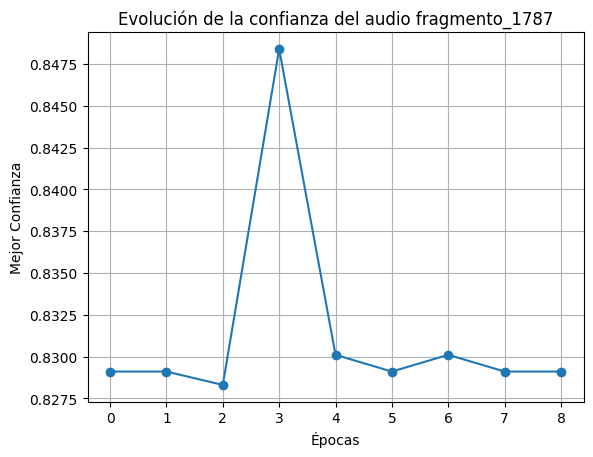


✅ Entrenamiento completado para fragmento_1787


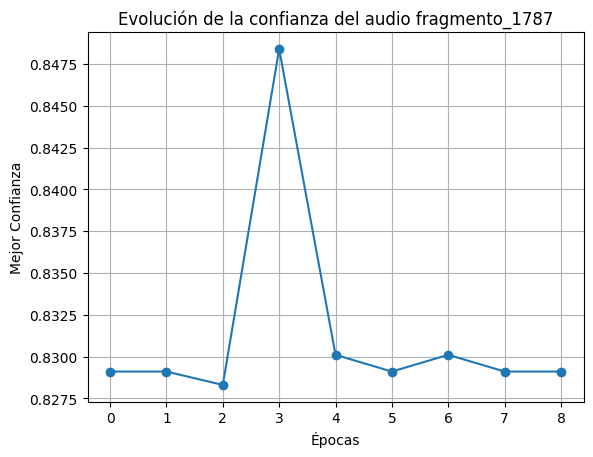


📋 Época 1/9 - Audio: fragmento_5822
📊 Mejor Confianza esta época: 0.617

📋 Época 2/9 - Audio: fragmento_5822
📊 Mejor Confianza esta época: 0.619

📋 Época 3/9 - Audio: fragmento_5822
📊 Mejor Confianza esta época: 0.621


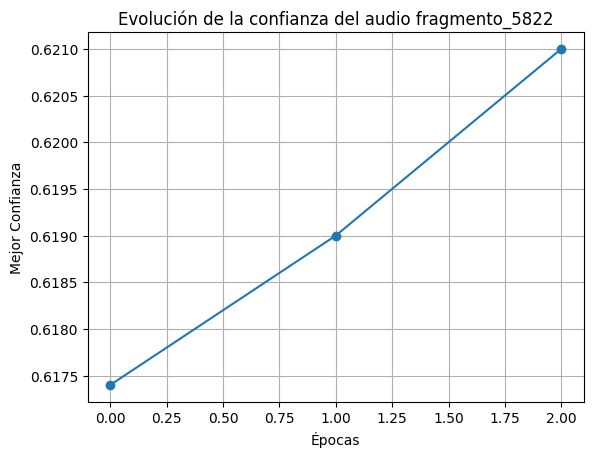


📋 Época 4/9 - Audio: fragmento_5822
📊 Mejor Confianza esta época: 0.612

📋 Época 5/9 - Audio: fragmento_5822
📊 Mejor Confianza esta época: 0.607

📋 Época 6/9 - Audio: fragmento_5822
📊 Mejor Confianza esta época: 0.610


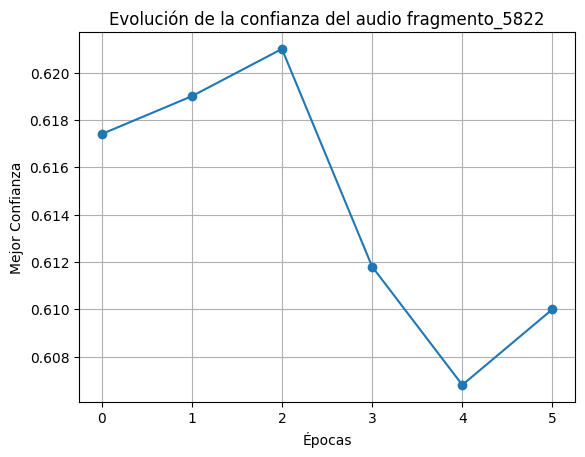


📋 Época 7/9 - Audio: fragmento_5822
📊 Mejor Confianza esta época: 0.617

📋 Época 8/9 - Audio: fragmento_5822
📊 Mejor Confianza esta época: 0.619

📋 Época 9/9 - Audio: fragmento_5822
📊 Mejor Confianza esta época: 0.609


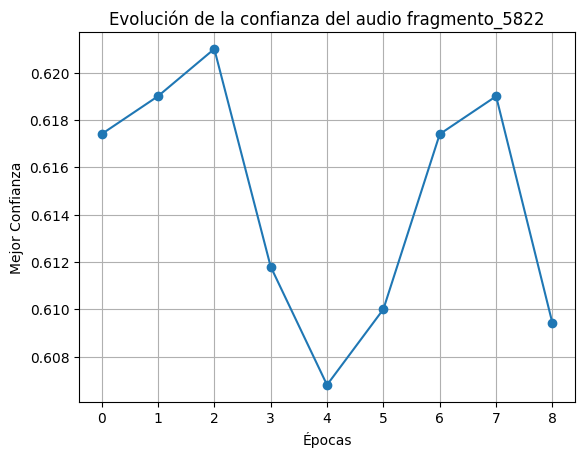


✅ Entrenamiento completado para fragmento_5822


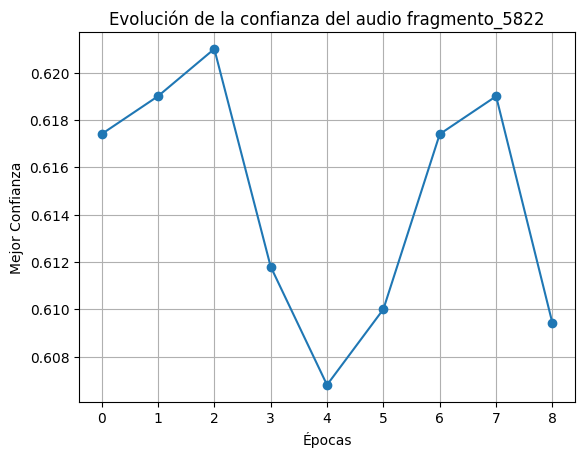


📋 Época 1/9 - Audio: fragmento_3502
📊 Mejor Confianza esta época: 0.961

📋 Época 2/9 - Audio: fragmento_3502
📊 Mejor Confianza esta época: 0.959

📋 Época 3/9 - Audio: fragmento_3502
📊 Mejor Confianza esta época: 0.961


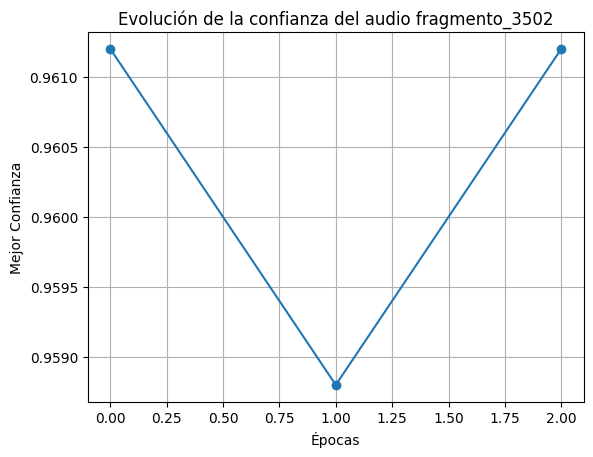


📋 Época 4/9 - Audio: fragmento_3502
📊 Mejor Confianza esta época: 0.961

📋 Época 5/9 - Audio: fragmento_3502
📊 Mejor Confianza esta época: 0.960

📋 Época 6/9 - Audio: fragmento_3502
📊 Mejor Confianza esta época: 0.962


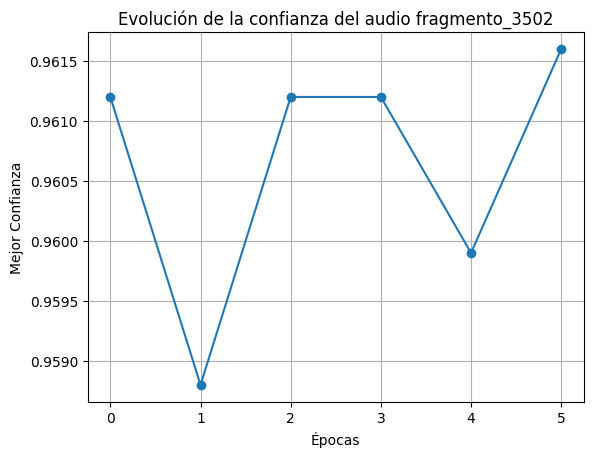


📋 Época 7/9 - Audio: fragmento_3502
📊 Mejor Confianza esta época: 0.959

📋 Época 8/9 - Audio: fragmento_3502
📊 Mejor Confianza esta época: 0.960

📋 Época 9/9 - Audio: fragmento_3502
📊 Mejor Confianza esta época: 0.959


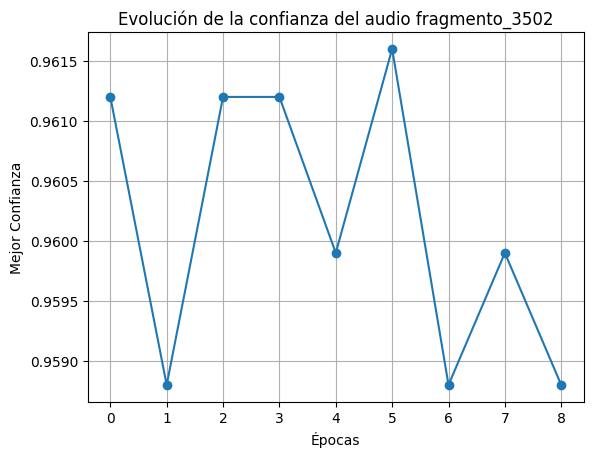


✅ Entrenamiento completado para fragmento_3502


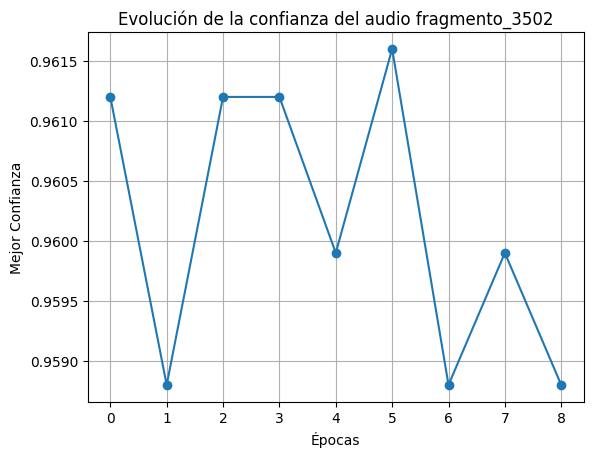

In [ ]:
import os, sys, shutil, random, subprocess
import numpy as np
import pandas as pd
import librosa, soundfile as sf
import matplotlib.pyplot as plt
from itertools import product
from scipy.signal import butter, lfilter


BASE_DIR = r"D:\GUSTAVO\CARPETA BASE"
TEMP_EVAL = os.path.join(BASE_DIR, "temp_eval")
TEMP_RESULT = os.path.join(BASE_DIR, "temp_eval_result")
RESULTS_CSV = os.path.join(BASE_DIR, "resultados_csv_birdnet")

for d in [BASE_DIR, TEMP_EVAL, TEMP_RESULT, RESULTS_CSV]:
    os.makedirs(d, exist_ok=True)

Q_VALS = [0.002, 0.003, 0.004, 0.005, 0.006, 0.0065]
R_VALS = [0.0035, 0.0045, 0.0055, 0.0065, 0.007]
F_VALS = [500, 1000, 1500, 2000, 2500]

ALPHA, GAMMA, EPSILON = 0.1, 0.9, 1.0
EPSILON_DECAY, EPSILON_MIN = 0.98, 0.01

LAT, LON, MIN_CONF = 10.45, -73.25, 0.1

NUM_EPOCHS = 9
STEPS_PER_EPOCH = 30
EARLY_STOPPING_WINDOW = 10
EARLY_STOPPING_DELTA = 0.01


AUDIO_DIR = r"D:\GUSTAVO\FRACMENTO\GRABADORA 2\dataset_(mayor a 0.3)"


def filtro_kalman(y, Q, R):
    x, P = y[0], 1.0
    x_est = np.zeros(len(y))
    for k in range(1, len(y)):
        x_pred, P_pred = x, P + Q
        K = P_pred / (P_pred + R)
        x = x_pred + K * (y[k] - x_pred)
        P = (1 - K) * P_pred
        x_est[k] = x
    return x_est

def filtro_pasabanda(y, lowcut, sr, highcut=8000):
    nyq = 0.5 * sr
    b, a = butter(4, [lowcut/nyq, highcut/nyq], btype='band')
    return lfilter(b, a, y)


class QLearningAgent:
    def __init__(self, actions):
        self.actions = actions
        self.q_table = pd.DataFrame({
            'Action': actions,
            'Q-Value': 0.0,
            'Last_Species': 'N/A',
            'Last_Reward': 0.0
        })
        self.alpha, self.gamma = ALPHA, GAMMA
        self.epsilon, self.eps_decay, self.eps_min = EPSILON, EPSILON_DECAY, EPSILON_MIN

    def choose_action(self):
        if np.random.rand() < self.epsilon:
            return random.randint(0, len(self.actions)-1)
        return self.q_table['Q-Value'].argmax()

    def learn(self, idx, reward, species):
        q_pred = self.q_table.loc[idx, 'Q-Value']
        q_target = reward + self.gamma * self.q_table['Q-Value'].max()
        self.q_table.loc[idx, 'Q-Value'] += self.alpha * (q_target - q_pred)

        if reward > self.q_table.loc[idx, 'Last_Reward']:
            self.q_table.loc[idx, ['Last_Reward', 'Last_Species']] = reward, species

    def decay_epsilon(self):
        if self.epsilon > self.eps_min:
            self.epsilon *= self.eps_decay


def llamar_birdnet(temp_audio, epoch, step, Q, R, F):
    subprocess.run([
        sys.executable, "-m", "birdnet_analyzer.analyze",
        TEMP_EVAL, "--output", TEMP_RESULT,
        "--lat", str(LAT), "--lon", str(LON),
        "--min_conf", str(MIN_CONF), "--rtype", "csv"
    ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    resultado_csv = next(
        (os.path.join(TEMP_RESULT, f) for f in os.listdir(TEMP_RESULT) if f.endswith(".BirdNET.results.csv")), None)

    reward, species = 0.0, "N/A"

    if resultado_csv:
        df = pd.read_csv(resultado_csv)

        df['File'] = df['File'].astype(str)
        df_filtrado = df[df['File'].str.contains(os.path.basename(temp_audio))]

        if not df_filtrado.empty:
            best = df_filtrado.loc[df_filtrado['Confidence'].idxmax()]
            reward, species = best['Confidence'], best['Scientific name']

        dest_csv = os.path.join(
            RESULTS_CSV,
            f"epoch{epoch+1}_step{step+1}_Q{Q}_R{R}_F{F}.csv"
        )
        shutil.move(resultado_csv, dest_csv)

    return reward, species


def graficar(recompensas, epoch=None, audio_name=None):
    plt.figure()
    plt.plot(recompensas, marker='o')
    plt.xlabel("Épocas")
    plt.ylabel("Mejor Confianza")
    plt.title(f"Evolución de la confianza del audio {audio_name}")
    plt.grid()

    graficas_dir = os.path.join(BASE_DIR, "graficas")
    os.makedirs(graficas_dir, exist_ok=True)
    filename = f"{audio_name}_epoch_{epoch+1}.png" if epoch is not None else f"{audio_name}_final.png"
    plt.savefig(os.path.join(graficas_dir, filename))
    plt.show()


def entrenar_audio(audio_path):
    acciones = list(product(Q_VALS, R_VALS, F_VALS))
    agente = QLearningAgent(acciones)
    recompensas = []

    y, sr = librosa.load(audio_path, sr=None)

    audio_name = os.path.splitext(os.path.basename(audio_path))[0]

    for epoch in range(NUM_EPOCHS):
        mejor_recompensa = 0.0

        print(f"\n Época {epoch+1}/{NUM_EPOCHS} - Audio: {audio_name}")
        for step in range(STEPS_PER_EPOCH):
            action_idx = agente.choose_action()
            Q, R, f_low = acciones[action_idx]

            y_k = filtro_kalman(y, Q, R)
            y_f = filtro_pasabanda(y_k, f_low, sr)

            nombre_temp = f"Q{Q}_R{R}_F{f_low}.wav"
            temp_audio = os.path.join(TEMP_EVAL, nombre_temp)
            sf.write(temp_audio, y_f, sr)

            reward, species = llamar_birdnet(temp_audio, epoch, step, Q, R, f_low)
            mejor_recompensa = max(mejor_recompensa, reward)

            agente.learn(action_idx, reward, species)

            os.remove(temp_audio)

        agente.decay_epsilon()
        recompensas.append(mejor_recompensa)

        print(f" Mejor Confianza esta época: {mejor_recompensa:.3f}")

        
        if (epoch+1) % 3 == 0 or (epoch+1) == NUM_EPOCHS:
            graficar(recompensas, epoch, audio_name)

        if len(recompensas) >= EARLY_STOPPING_WINDOW:
            ultimas = recompensas[-EARLY_STOPPING_WINDOW:]
            if max(ultimas) - min(ultimas) < EARLY_STOPPING_DELTA:
                print(f" Early stopping: sin mejoras significativas en las últimas {EARLY_STOPPING_WINDOW} épocas.")
                break

    print(f"\n Entrenamiento completado para {audio_name}")
    graficar(recompensas, audio_name=audio_name)


if __name__ == "__main__":
    todos_los_audios = [os.path.join(AUDIO_DIR, f) for f in os.listdir(AUDIO_DIR) if f.endswith('.wav')]
    audios_elegidos = random.sample(todos_los_audios, 3)

    for audio in audios_elegidos:
        entrenar_audio(audio)




### Etapa 2- Filtrado, confianza, entrenamiento, actualizacion tabla, decaimiento y comparacion

Este script se encarga de las etapas siguientes del proyecto, que incluyen la aplicación de filtros a los audios, la evaluación de los resultados con BirdNET, el entrenamiento del agente de aprendizaje por refuerzo (Q-learning) y la comparación final de los resultados. Dentro de este bloque, BASE_DIR define la ruta principal donde se guardan los archivos generados, como resultados, gráficas y archivos temporales. TEMP_EVAL y TEMP_RESULT almacenan los archivos temporales requeridos para la ejecución de BirdNET en cada iteración, mientras que RESULTS_CSV guarda los resultados filtrados obtenidos tras el procesamiento. La variable ORIGINAL_CSV_DIR apunta a los resultados originales de BirdNET sin filtros aplicados, y se utiliza como referencia para medir el impacto del agente en la mejora de la confianza. Por su parte, DATASET_DIR debe contener los fragmentos de audio .wav previamente generados; aunque por convención esta carpeta sería D:\GUSTAVO\salida_birdnet, en este experimento se utilizó la ruta D:\GUSTAVO\FRACMENTO\GRABADORA 2\dataset_(mayor a 0.3) ya que se construyó un pequeño conjunto de datos que contenía audios con alta probabilidad de aves (confianza conocida mayor a 0.3). Durante la ejecución, el script aplica combinaciones de filtros (Q, R, F), evalúa cada fragmento con BirdNET, obtiene una recompensa (nivel de confianza), actualiza la tabla Q, ajusta el parámetro epsilon para balancear exploración y explotación, y repite el proceso con el siguiente fragmento.

---

### Variables clave que debe ajustar el usuario

- **`BASE_DIR`**: Ruta principal donde se almacenan resultados y archivos temporales.
- **`AUDIO_DIR`**: Carpeta donde están los audios `.wav` a analizar.
- **`Q_VALS`, `R_VALS`, `F_VALS`**: Rangos de parámetros para los filtros Kalman y pasabanda.
- **`N_EPOCHS`, `MAX_STEPS`**: Controlan la duración del entrenamiento (cantidad de pruebas realizadas por audio).
- **`EPSILON`, `GAMMA`, `ALPHA`**: Hiperparámetros del agente Q-learning.
- **`N_AUDIOS`**: Numero de audios a procesar.

El código genera una grafica de cuanta fue la mejora de los audios en base a la confianza inicial y la obtenida luego de los filtros, csv donde se guardan los diferentes datos como confianza inicial, final, y mejores filtros para dicho audio etc.

In [ ]:
import os, sys, shutil, random, subprocess
import numpy as np
import pandas as pd
import librosa, soundfile as sf
from itertools import product
from scipy.signal import butter, lfilter
from datetime import datetime
import matplotlib.pyplot as plt


BASE_DIR = r"D:\GUSTAVO\CARPETA BASE"
TEMP_EVAL = os.path.join(BASE_DIR, "temp_eval")
TEMP_RESULT = os.path.join(BASE_DIR, "temp_eval_result")
RESULTS_CSV = os.path.join(BASE_DIR, "resultados_csv_birdnet")
ORIGINAL_CSV_DIR = r"D:\GUSTAVO\salida_birdnet"

DATASET_DIR = r"D:\GUSTAVO\FRACMENTO\GRABADORA 2\dataset_(mayor a 0.3)"

for d in [BASE_DIR, TEMP_EVAL, TEMP_RESULT, RESULTS_CSV]:
    os.makedirs(d, exist_ok=True)

Q_VALS = [0.002, 0.003, 0.004, 0.005, 0.006, 0.0065]
R_VALS = [0.0035, 0.0045, 0.0055, 0.0065, 0.007]
F_VALS = [500, 1000, 1500, 2000, 2500]

ALPHA, GAMMA, EPSILON = 0.1, 0.9, 1.0
EPSILON_DECAY, EPSILON_MIN = 0.98, 0.01

LAT, LON, MIN_CONF = 10.45, -73.25, 0.1

NUM_EPOCHS = 9
STEPS_PER_EPOCH = 30

N_AUDIOS = 50  


def filtro_kalman(y, Q, R):
    x, P = y[0], 1.0
    x_est = np.zeros(len(y))
    for k in range(1, len(y)):
        x_pred, P_pred = x, P + Q
        K = P_pred / (P_pred + R)
        x = x_pred + K * (y[k] - x_pred)
        P = (1 - K) * P_pred
        x_est[k] = x
    return x_est

def filtro_pasabanda(y, lowcut, sr, highcut=8000):
    nyq = 0.5 * sr
    b, a = butter(4, [lowcut/nyq, highcut/nyq], btype='band')
    return lfilter(b, a, y)


class QLearningAgent:
    def __init__(self, actions):
        self.actions = actions
        self.q_table = pd.DataFrame({
            'Action': actions,
            'Q-Value': 0.0,
            'Last_Species': 'N/A',
            'Last_Reward': 0.0
        })
        self.alpha, self.gamma = ALPHA, GAMMA
        self.epsilon, self.eps_decay, self.eps_min = EPSILON, EPSILON_DECAY, EPSILON_MIN

    def choose_action(self):
        if np.random.rand() < self.epsilon:
            return random.randint(0, len(self.actions)-1)
        return self.q_table['Q-Value'].argmax()

    def learn(self, idx, reward, species):
        q_pred = self.q_table.loc[idx, 'Q-Value']
        q_target = reward + self.gamma * self.q_table['Q-Value'].max()
        self.q_table.loc[idx, 'Q-Value'] += self.alpha * (q_target - q_pred)

        if reward > self.q_table.loc[idx, 'Last_Reward']:
            self.q_table.loc[idx, ['Last_Reward', 'Last_Species']] = reward, species

    def decay_epsilon(self):
        if self.epsilon > self.eps_min:
            self.epsilon *= self.eps_decay


def llamar_birdnet(temp_audio, epoch, step, Q, R, F, audio_name):
    subprocess.run([
        sys.executable, "-m", "birdnet_analyzer.analyze",
        TEMP_EVAL, "--output", TEMP_RESULT,
        "--lat", str(LAT), "--lon", str(LON),
        "--min_conf", str(MIN_CONF), "--rtype", "csv"
    ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    resultado_csv = next(
        (os.path.join(TEMP_RESULT, f) for f in os.listdir(TEMP_RESULT) if f.endswith(".BirdNET.results.csv")), None)

    reward, species = 0.0, "N/A"

    if resultado_csv:
        df = pd.read_csv(resultado_csv)

        df['File'] = df['File'].astype(str)
        df_filtrado = df[df['File'].str.contains(os.path.basename(temp_audio))]

        if not df_filtrado.empty:
            best = df_filtrado.loc[df_filtrado['Confidence'].idxmax()]
            reward, species = best['Confidence'], best['Common name']  
        dest_csv = os.path.join(
            RESULTS_CSV,
            f"{audio_name}_epoch{epoch+1}_step{step+1}_Q{Q}_R{R}_F{F}.csv"
        )
        shutil.move(resultado_csv, dest_csv)

    return reward, species


def entrenar_audio(audio_path):
    acciones = list(product(Q_VALS, R_VALS, F_VALS))
    agente = QLearningAgent(acciones)

    y, sr = librosa.load(audio_path, sr=None)
    audio_name = os.path.splitext(os.path.basename(audio_path))[0]

    mejor_global = 0.0
    mejor_filtros = (0, 0, 0)
    mejor_especie = "N/A"

    for epoch in range(NUM_EPOCHS):
        for step in range(STEPS_PER_EPOCH):
            action_idx = agente.choose_action()
            Q, R, f_low = acciones[action_idx]

            y_k = filtro_kalman(y, Q, R)
            y_f = filtro_pasabanda(y_k, f_low, sr)

            nombre_temp = f"{audio_name}_Q{Q}_R{R}_F{f_low}.wav"
            temp_audio = os.path.join(TEMP_EVAL, nombre_temp)
            sf.write(temp_audio, y_f, sr)

            reward, species = llamar_birdnet(temp_audio, epoch, step, Q, R, f_low, audio_name)

            if reward > mejor_global:
                mejor_global = reward
                mejor_filtros = (Q, R, f_low)
                mejor_especie = species

            agente.learn(action_idx, reward, species)
            os.remove(temp_audio)

        agente.decay_epsilon()

    print(f"\n {audio_name} completado. Mejor confianza: {mejor_global:.3f}")
    return audio_name, mejor_global, mejor_filtros, mejor_especie


def comparar_resultados(mejores_conf):
    tabla = []
    for audio_name, (mejor_conf, (q, r, f), mejor_especie) in mejores_conf.items():
        original_txt = os.path.join(ORIGINAL_CSV_DIR, f"{audio_name}.BirdNET.selection.table.txt")
        if os.path.exists(original_txt):
            try:
                df = pd.read_csv(original_txt, sep='\t')
                if 'Confidence' in df.columns and not df.empty:
                    especie_match = df[df['Common Name'] == mejor_especie]

                    if not especie_match.empty:
                        original_conf = especie_match['Confidence'].max()
                        original_especie = mejor_especie
                        coinciden = '✅'
                    else:
                        original_conf = 0.0
                        original_especie = 'N/A'
                        coinciden = '❌ (especie no encontrada)'
                else:
                    print(f" Archivo {original_txt} vacío o sin 'Confidence'.")
                    original_conf, original_especie, coinciden = 0.0, 'N/A', '❌'
            except Exception as e:
                print(f"❌ Error leyendo {original_txt}: {e}")
                original_conf, original_especie, coinciden = np.nan, 'N/A', '❌'
        else:
            print(f" Archivo original no encontrado: {original_txt}")
            original_conf, original_especie, coinciden = np.nan, 'N/A', '❌'

        tabla.append({
            'Audio': audio_name,
            'Original_Conf': original_conf,
            'Original_Especie': original_especie,
            'Con_Filtros_Conf': mejor_conf,
            'Con_Filtros_Especie': mejor_especie,
            'Mejora': mejor_conf - original_conf if pd.notnull(original_conf) else np.nan,
            'Q': q,
            'R': r,
            'F': f,
            'Coinciden': coinciden
        })

    tabla_df = pd.DataFrame(tabla)
    tabla_df = tabla_df.sort_values(by='Mejora', ascending=False)

    print("\n Comparación de resultados (por misma especie):")
    print(tabla_df)

    
    tabla_df.to_csv(os.path.join(BASE_DIR, "comparacion_resultados.csv"), index=False)

    
    fecha = datetime.now().strftime("%Y%m%d_%H%M%S")

    excel_path = os.path.join(BASE_DIR, f"comparacion_resultados_{fecha}.xlsx")
    png_path = os.path.join(BASE_DIR, f"mejora_confianza_{fecha}.png")

    tabla_df.to_excel(excel_path, index=False)

    plt.figure(figsize=(10, 6))
    plt.barh(tabla_df['Audio'], tabla_df['Mejora'], color='skyblue')
    plt.xlabel("Mejora en Confianza")
    plt.ylabel("Audio")
    plt.title("Mejora de confianza por audio")
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.savefig(png_path)
    plt.close()

    print(f"\n Resultados guardados en:\n CSV: comparacion_resultados.csv\n Excel: {excel_path}\n Gráfico: {png_path}")


if __name__ == "__main__":
    audios = [os.path.join(DATASET_DIR, f) for f in os.listdir(DATASET_DIR) if f.endswith(".wav")]
    random.shuffle(audios)
    audios = audios[:N_AUDIOS]

    mejores_confianzas = {}

    for audio_path in audios:
        nombre, mejor, filtros, especie = entrenar_audio(audio_path)
        mejores_confianzas[nombre] = (mejor, filtros, especie)

    comparar_resultados(mejores_confianzas)



✅ fragmento_95 completado. Mejor confianza: 0.882

✅ fragmento_3516 completado. Mejor confianza: 0.985

✅ fragmento_7400 completado. Mejor confianza: 0.190

✅ fragmento_3508 completado. Mejor confianza: 0.975

✅ fragmento_2007 completado. Mejor confianza: 0.274

✅ fragmento_49 completado. Mejor confianza: 0.943

✅ fragmento_7219 completado. Mejor confianza: 0.338

✅ fragmento_7342 completado. Mejor confianza: 0.414

✅ fragmento_1925 completado. Mejor confianza: 0.489

✅ fragmento_2056 completado. Mejor confianza: 0.389

✅ fragmento_43 completado. Mejor confianza: 0.993

✅ fragmento_7397 completado. Mejor confianza: 0.398

✅ fragmento_2679 completado. Mejor confianza: 0.758

✅ fragmento_7363 completado. Mejor confianza: 0.243

✅ fragmento_379 completado. Mejor confianza: 0.220

✅ fragmento_579 completado. Mejor confianza: 0.232

✅ fragmento_7375 completado. Mejor confianza: 0.137

✅ fragmento_2049 completado. Mejor confianza: 0.832

✅ fragmento_2634 completado. Mejor confianza: 0.494



### Validación de BirdNET con el dataset BirdCLEF 2025+ parte-1

Con el fin de validar la confiabilidad del modelo BirdNET al momento de identificar especies de aves, se utilizó el dataset BirdCLEF 2025+, el cual contiene grabaciones de audio previamente etiquetadas por expertos. Este conjunto de datos incluye un archivo CSV llamado `taxonomy.csv`, donde se especifica el nombre científico de cada especie y la carpeta en la que se encuentran los audios correspondientes.

Se realizó una búsqueda manual dentro de este archivo y la pagina oficial de birdnet para seleccionar especies que cumplen con dos condiciones clave: (1) están presentes en el archivo `taxonomy.csv`, y (2) están reconocidas dentro de la base de datos de BirdNET, los resultados arrojaron 13 especies esto garantiza que BirdNET pueda identificar estas especies con certeza.

El siguiente script tiene como objetivo obtener un mapeo entre los nombres científicos de estas especies seleccionadas y sus respectivas etiquetas o carpetas dentro del dataset. Para ello, se define una lista con los nombres científicos de interés, se carga el archivo `taxonomy.csv` utilizando la biblioteca `pandas`, se filtran únicamente las especies deseadas, y se crea un diccionario (`mapeo`) que relaciona cada nombre científico con su `primary_label`, es decir, el nombre de la carpeta correspondiente. Finalmente, se imprime dicho mapeo para verificar qué especies fueron encontradas exitosamente en el archivo CSV. Esta relación es esencial para acceder correctamente a los audios específicos por especie y validar el rendimiento del modelo BirdNET.

In [ ]:
import pandas as pd

# lista de especies científicas objetivo
especies_objetivo = [
    "Nyctidromus albicollis",
    "Coragyps atratus",
    "Tyrannus melancholicus",
    "Caracara plancus",            
    "Butorides striata",
    "Megascops choliba",
    "Cathartes aura",
    "Porphyrio martinica",
    "Egretta thula",
    "Tringa solitaria",
    "Setophaga pitiayumi",
    "Leptotila verreauxi",
    "Mycteria americana"
]

def obtener_mapeo(ruta_csv):
    
    df = pd.read_csv(ruta_csv)

    
    df_filtrado = df[df['scientific_name'].isin(especies_objetivo)]

    
    mapeo = dict(zip(df_filtrado['scientific_name'], df_filtrado['primary_label']))

    return mapeo


ruta = r"D:\GUSTAVO\birdclef-2025\taxonomy.csv"
mapeo = obtener_mapeo(ruta)

print("\n=== Especie → Carpeta ===\n")
for especie in especies_objetivo:
    carpeta = mapeo.get(especie)
    if carpeta:
        print(f" {especie} → {carpeta}")
    else:
        print(f" No encontrada: {especie}")




=== Especie → Carpeta ===

✅ Nyctidromus albicollis → compau
✅ Coragyps atratus → blkvul
✅ Tyrannus melancholicus → trokin
✅ Caracara plancus → y00678
✅ Butorides striata → strher
✅ Megascops choliba → trsowl
✅ Cathartes aura → turvul
✅ Porphyrio martinica → purgal2
✅ Egretta thula → snoegr
✅ Tringa solitaria → solsan
✅ Setophaga pitiayumi → tropar
✅ Mycteria americana → woosto
✅ Leptotila verreauxi → whtdov
✅ Mycteria americana → woosto


### Validación de BirdNET con el dataset BirdCLEF 2025+ parte-2
### Evaluación de precisión de BirdNET con audios etiquetados (BirdCLEF 2025+)

Esta sección del proyecto tiene como propósito validar cuán precisa es la confianza arrojada por BirdNET al identificar especies de aves, utilizando audios reales del dataset BirdCLEF 2025+.

Partiendo del mapeo generado anteriormente entre especies científicas y sus respectivas carpetas dentro del dataset, este script recorre 13 especies previamente seleccionadas (las cuales están confirmadas tanto en BirdNET como en BirdCLEF). De cada especie, se toman hasta 25 audios aleatorios en formato `.ogg`, y se procesan individualmente con BirdNET usando un comando en terminal vía `subprocess`.

---

#### Flujo del proceso:

1. **Configuración de parámetros**: Se definen rutas importantes como la carpeta de BirdNET, la carpeta de audios (`train_audio`) la cual es donde se encuentran las carpetas de audios etiquetados al descargar el dataset de birdCLEFF, y el directorio donde se guardarán los resultados CSV generados por BirdNET. También se establecen los parámetros geográficos (LAT, LON) y los umbrales de confianza.

2. **Procesamiento de audios**:
   - Por cada especie, se seleccionan hasta 25 audios.
   - Cada audio se pasa a BirdNET para obtener su predicción y nivel de confianza.
   - El resultado se guarda en un archivo `.csv` por audio, el cual es analizado para extraer la especie predicha y su confianza máxima.
   - Si el proceso falla o no genera resultados, se registran errores correspondientes.

3. **Registro de resultados**: Se genera un `DataFrame` con los datos recopilados, incluyendo:
   - Especie esperada
   - Archivo procesado
   - Especie predicha por BirdNET
   - Nivel de confianza
   - Indicador binario de acierto (1 si coincide la predicción con la especie esperada)

4. **Evaluación de aciertos**:
   - Se calcula el porcentaje de aciertos por especie (cuántas veces BirdNET predijo correctamente la especie).
   - Se guarda un archivo `.csv` con todos los resultados consolidados.
   - Se genera una gráfica de barras mostrando el porcentaje de aciertos por especie.

Este bloque es esencial para verificar si BirdNET responde de forma consistente a audios donde la especie es conocida de antemano, sirviendo como una validación objetiva.


In [ ]:
import os
import subprocess
import pandas as pd
import random
import glob
import matplotlib.pyplot as plt


CARPETA_BIRDNET = r"D:\GUSTAVO\BirdNET-Analyzer-main"
CARPETA_BASE = r"D:\GUSTAVO\birdclef-2025\train_audio"
CARPETA_SALIDA_BIRDNET = r"D:\GUSTAVO\salida_birdnet\CSV_audios_birdcleff"
LAT = "4.57"
LON = "-74.29"
MIN_CONF = "0.2"
SENS = "1.0"
CSV_FINAL = r"D:\GUSTAVO\resultados_25_por_carpeta.csv"
GRAFICA_FINAL = r"D:\GUSTAVO\grafica_aciertos.png"

os.makedirs(CARPETA_SALIDA_BIRDNET, exist_ok=True)

# === Mapeo especie → carpeta ===
especie_carpeta = {
    "Nyctidromus albicollis": "compau",
    "Coragyps atratus": "blkvul",
    "Tyrannus melancholicus": "trokin",
    "Caracara plancus": "y00678",
    "Butorides striata": "strher",
    "Megascops choliba": "trsowl",
    "Cathartes aura": "turvul",
    "Porphyrio martinica": "purgal2",
    "Egretta thula": "snoegr",
    "Tringa solitaria": "solsan",
    "Setophaga pitiayumi": "tropar",
    "Mycteria americana": "woosto",
    "Leptotila verreauxi": "whtdov"
}

resultados = []

for especie, carpeta in especie_carpeta.items():
    carpeta_path = os.path.join(CARPETA_BASE, carpeta)
    archivos = [f for f in os.listdir(carpeta_path) if f.lower().endswith(".ogg")]
    if not archivos:
        print(f" No hay archivos en {carpeta}")
        continue

    seleccionados = random.sample(archivos, min(25, len(archivos)))
    print(f"\n Analizando 25 audios de {carpeta} ({especie})")

    for idx, archivo in enumerate(seleccionados, 1):
        ruta_audio = os.path.join(carpeta_path, archivo)
        nombre_base = os.path.splitext(archivo)[0]  

        comando = [
            "python", "-m", "birdnet_analyzer.analyze",
            ruta_audio,
            "--output", CARPETA_SALIDA_BIRDNET,
            "--lat", LAT,
            "--lon", LON,
            "--sensitivity", SENS,
            "--min_conf", MIN_CONF,
            "--rtype", "csv"
        ]

        resultado = subprocess.run(
            comando,
            cwd=CARPETA_BIRDNET,
            capture_output=True,
            text=True
        )

        if resultado.returncode != 0:
            print(f" Error en {archivo}: {resultado.stderr}")
            ave_predicha = "Error"
            confianza = 0.0
            resultados.append([especie, carpeta, archivo, idx, ave_predicha, confianza])
            continue

        
        pattern = os.path.join(
            CARPETA_SALIDA_BIRDNET,
            f"{nombre_base}*.BirdNET.results.csv"
        )
        archivos_csv = glob.glob(pattern)

        if not archivos_csv:
            print(f" No se encontró ningún CSV para {archivo}")
            ave_predicha = "N/A"
            confianza = 0.0

        else:
            ruta_csv = archivos_csv[0]  

            try:
                df = pd.read_csv(ruta_csv)

                if df.empty:
                    ave_predicha = "N/A"
                    confianza = 0.0
                else:
                    df_filtrado = df[df["File"].str.contains(archivo, case=False, na=False)]
                    if df_filtrado.empty:
                        ave_predicha = "N/A"
                        confianza = 0.0
                    else:
                        row_max = df_filtrado.loc[df_filtrado['Confidence'].idxmax()]
                        ave_predicha = row_max['Scientific name']
                        confianza = row_max['Confidence']

            except Exception as e:
                print(f" Error procesando CSV para {archivo}: {e}")
                ave_predicha = "Error"
                confianza = 0.0

        print(f"[{idx:02d}] {archivo} → {ave_predicha} ({confianza:.3f})")
        resultados.append([especie, carpeta, archivo, idx, ave_predicha, confianza])


df_resultados = pd.DataFrame(resultados, columns=[
    "especie_esperada", "carpeta", "archivo", "n_audio",
    "ave_predicha", "confianza"
])

df_resultados.to_csv(CSV_FINAL, index=False, encoding="utf-8")
print(f"\n CSV final guardado en: {CSV_FINAL}")


df_resultados["acierto"] = df_resultados.apply(
    lambda row: 1 if row["ave_predicha"].lower() == row["especie_esperada"].lower() else 0,
    axis=1
)

resumen = df_resultados.groupby("especie_esperada")["acierto"].agg(["sum", "count"])
resumen["porcentaje_acierto"] = 100 * resumen["sum"] / resumen["count"]

print("\n Resumen de aciertos por especie:\n")
print(resumen)


plt.figure(figsize=(12, 6))
plt.bar(resumen.index, resumen["porcentaje_acierto"], color="skyblue")
plt.ylabel("Porcentaje de aciertos (%)")
plt.xlabel("Especie")
plt.title("Porcentaje de aciertos de BirdNET por especie (25 audios por especie)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig(GRAFICA_FINAL, dpi=300)
plt.close()

print(f"\n Gráfica guardada en: {GRAFICA_FINAL}")
print("\n Proceso finalizado.")



🚀 Analizando 25 audios de compau (Nyctidromus albicollis)
[01] XC857625.ogg → Nyctidromus albicollis (1.000)
[02] XC128797.ogg → Nyctidromus albicollis (0.947)
[03] iNat408157.ogg → Nyctidromus albicollis (0.987)
[04] XC688820.ogg → Nyctidromus albicollis (0.996)
[05] iNat1217423.ogg → Nyctidromus albicollis (0.864)
[06] iNat45888.ogg → Nyctidromus albicollis (0.998)
[07] iNat27443.ogg → Nyctidromus albicollis (0.989)
[08] iNat714050.ogg → Nyctidromus albicollis (0.840)
[09] iNat628080.ogg → Nyctidromus albicollis (0.994)
[10] XC525623.ogg → Nyctidromus albicollis (0.745)
[11] iNat935127.ogg → Nyctidromus albicollis (0.782)
[12] XC192097.ogg → Nyctidromus albicollis (0.991)
[13] iNat791004.ogg → Nyctidromus albicollis (0.973)
[14] XC922085.ogg → Nyctidromus albicollis (0.990)
[15] XC145933.ogg → Nyctidromus albicollis (0.994)
[16] iNat902169.ogg → Nyctidromus albicollis (0.720)
[17] XC403926.ogg → N/A (0.000)
[18] XC671534.ogg → Nyctidromus albicollis (0.986)
[19] iNat419336.ogg → Cic

### Experimento 2 - Comparación entre audios originales y filtrados (validación vía espectrogramas y BirdNET)

Este segundo experimento tiene como objetivo evaluar el impacto de los filtros de procesamiento de audio (Kalman y pasabanda) en los resultados de BirdNET. El script compara directamente la versión original de un audio con su versión filtrada. Además, se generan espectrogramas que permiten visualizar las diferencias espectrales entre ambas versiones.

---

####  Objetivo principal

El objetivo principal de este script es validar visualmente y cuantitativamente si el proceso de filtrado mejora, mantiene o degrada la identificación de especies por parte de BirdNET. Para ello:

- Se mide la **confianza** de BirdNET en la predicción de la especie para ambas versiones (original y filtrada).
- Se generan **espectrogramas Mel** para observar visualmente las diferencias acústicas introducidas por el filtrado.

---

####  Flujo del experimento

1. **Selección del audio**:
   - Se escoge un archivo `.wav` con alta probabilidad de contener canto de aves (confianza > 0.3 según BirdNET).

2. **Parámetros óptimos**:
   - Se utilizan los **valores óptimos previamente encontrados durante el entrenamiento**:
     - Parámetros `Q` y `R` del filtro de Kalman.
     - Frecuencia de corte inferior `F` del filtro pasabanda.
   - Estos valores representan las mejores configuraciones encontradas para maximizar la confianza en la identificación de la especie.

3. **Filtrado del audio**:
   - Se aplica primero el **filtro de Kalman** para suavizar la señal.
   - Luego, un **filtro pasabanda** entre `F` Hz (frecuencia óptima) y 8 kHz.
   - El resultado se guarda como un nuevo archivo `.wav` filtrado.

4. **Evaluación con BirdNET**:
   - Ambos archivos (original y filtrado) se procesan con BirdNET.
   - Se extrae la especie detectada y la puntuación de confianza.
   - Los resultados se guardan en archivos `.csv` separados.

5. **Visualización con espectrogramas**:
   - Se generan espectrogramas Mel usando `librosa` para las dos versiones del audio.
   - Esto permite comparar visualmente cómo los filtros afectan el contenido frecuencial de la señal.

---

#### Resultados esperados

- Dos impresiones por consola con la especie detectada y la confianza obtenida por BirdNET:
  - `[ORIGINAL] Especie: ..., Confianza: ...`
  - `[FILTRADO] Especie: ..., Confianza: ...`
- Dos espectrogramas guardados como imágenes `.png`:
  - `espectrograma_original_nombre.wav.png`
  - `espectrograma_filtrado_nombre.wav.png`
- Archivos `.csv` con los resultados de BirdNET para cada versión del audio.

Este experimento no solo valida si el filtrado mejora la capacidad de detección de BirdNET, sino que también permite entender cómo cambia la señal acústica visualmente, ofreciendo una perspectiva complementaria para evaluar la utilidad de los filtros aplicados.


In [ ]:
import os, sys, shutil, subprocess
import numpy as np
import pandas as pd
import librosa, soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import butter, lfilter


AUDIO_PATH = r"D:\GUSTAVO\FRACMENTO\GRABADORA 2\dataset_(mayor a 0.3)\fragmento_3508.wav"
BASE_DIR = r"D:\GUSTAVO\salida_birdnet\ESPECTOGRAMAS"
Q = 0.005
R = 0.007
F = 500

TEMP_EVAL = os.path.join(BASE_DIR, "temp_eval")
TEMP_RESULT = os.path.join(BASE_DIR, "temp_eval_result")
RESULTS_CSV = os.path.join(BASE_DIR, "resultados_csv_birdnet")

for d in [BASE_DIR, TEMP_EVAL, TEMP_RESULT, RESULTS_CSV]:
    os.makedirs(d, exist_ok=True)

LAT, LON, MIN_CONF = 10.45, -73.25, 0.1


def filtro_kalman(y, Q, R):
    x, P = y[0], 1.0
    x_est = np.zeros(len(y))
    for k in range(1, len(y)):
        x_pred, P_pred = x, P + Q
        K = P_pred / (P_pred + R)
        x = x_pred + K * (y[k] - x_pred)
        P = (1 - K) * P_pred
        x_est[k] = x
    return x_est

def filtro_pasabanda(y, lowcut, sr, highcut=8000):
    nyq = 0.5 * sr
    b, a = butter(4, [lowcut/nyq, highcut/nyq], btype='band')
    return lfilter(b, a, y)

def generar_espectrograma(y, sr, titulo, path_out):
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=1024, hop_length=256, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_dB, sr=sr, hop_length=256, x_axis='time', y_axis='mel', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(titulo)
    plt.tight_layout()
    plt.savefig(path_out)
    plt.close()

def llamar_birdnet(temp_audio_path, nombre_salida_csv):
    subprocess.run([
        sys.executable, "-m", "birdnet_analyzer.analyze",
        TEMP_EVAL, "--output", TEMP_RESULT,
        "--lat", str(LAT), "--lon", str(LON),
        "--min_conf", str(MIN_CONF), "--rtype", "csv"
    ], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    resultado_csv = next((os.path.join(TEMP_RESULT, f)
                          for f in os.listdir(TEMP_RESULT)
                          if f.endswith(".BirdNET.results.csv")), None)

    reward, species = 0.0, "N/A"

    if resultado_csv:
        df = pd.read_csv(resultado_csv)
        df['File'] = df['File'].astype(str)
        df_filtrado = df[df['File'].str.contains(os.path.basename(temp_audio_path))]

        if not df_filtrado.empty:
            best = df_filtrado.loc[df_filtrado['Confidence'].idxmax()]
            reward, species = best['Confidence'], best['Scientific name']

        dest_csv = os.path.join(RESULTS_CSV, nombre_salida_csv)
        shutil.move(resultado_csv, dest_csv)

    return reward, species


def procesar_audio():
    y, sr = librosa.load(AUDIO_PATH, sr=None)
    filename = os.path.basename(AUDIO_PATH)

    
    temp_original = os.path.join(TEMP_EVAL, filename)
    shutil.copy(AUDIO_PATH, temp_original)

    
    reward1, species1 = llamar_birdnet(temp_original, f"original_{filename}.csv")
    print(f"[ORIGINAL] Especie: {species1}, Confianza: {reward1:.3f}")

    espectro1 = os.path.join(BASE_DIR, f"espectrograma_original_{filename}.png")
    generar_espectrograma(y, sr, "Original", espectro1)

   
    y_k = filtro_kalman(y, Q, R)
    y_f = filtro_pasabanda(y_k, F, sr)

    filename_filt = f"filtrado_{filename}"
    path_filt = os.path.join(TEMP_EVAL, filename_filt)
    sf.write(path_filt, y_f, sr)

    reward2, species2 = llamar_birdnet(path_filt, f"filtrado_{filename}.csv")
    print(f"[FILTRADO] Especie: {species2}, Confianza: {reward2:.3f}")

    espectro2 = os.path.join(BASE_DIR, f"espectrograma_filtrado_{filename}.png")
    generar_espectrograma(y_f, sr, "Filtrado", espectro2)


if __name__ == "__main__":
    procesar_audio()

[ORIGINAL] Especie: Herpetotheres cachinnans, Confianza: 0.468
[FILTRADO] Especie: Herpetotheres cachinnans, Confianza: 0.975
